## This notebook contains some extra analysis including venn diagrams for understanding the overlapping between peptides from HLA imputation study in Agilent and Twist libraries. Then creating fasta file for all proteins with complete AA sequence

In [16]:
# Peptides from associations
# Load SupTable2.3 table and extract relevant columns: for each duplicate take minimum value of bonferroni and concatenate type
# of mutations.
# HLA only associated
import pandas as pd
import matplotlib.pyplot as plt
from venn import venn2

In [2]:


df = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.3')
# General associated
df2 = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.2')


In [3]:
df3 = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.1')

In [4]:
peptides_HLA = df.sort_values(by='peptide')
grouped_peptide_variant = peptides_HLA.groupby(['Type', 'peptide']).count()[['Variant']].reset_index()
grouped_peptide_variant.columns = ['Type', 'peptide', 'count']

In [5]:
len(set(df2['peptide']))

511

In [13]:
# Compute relative abundance in twist and agilent
import matplotlib.pyplot as plt
import seaborn as sns
# This function is for computing and plotting relative abundances between different associations (HLA, SNP, insertion, aminoacid)
# in both twist and agilent libraries
def compute_counts_and_rel_ab(df_peptides):
    # Define libraries
    libraries = ['agilent', 'twist']
    
    # Compute overal counts
    peptides_HLA = df_peptides.sort_values(by='peptide')
    grouped_peptide_variant = peptides_HLA.groupby(['Type', 'peptide']).count()[['Variant']].reset_index()
    grouped_peptide_variant.columns = ['Type', 'peptide', 'counts']
    
    # List to take the 2 df originated in the loop
    list_df = []
    
    # Loop over agilent and twist peptides
    for i in libraries:
        print(len(peptides_HLA[peptides_HLA['peptide'].str.contains(i)]['peptide'].unique()))
        group_counts = peptides_HLA[peptides_HLA['peptide'].str.contains(i)].groupby('Type').count()[['Variant']].reset_index()
        group_counts.columns = ['Type', 'counts']
        sum_group = group_counts[['counts']].sum(axis=0)
        group_counts['rel_counts'] = (group_counts[['counts']] / sum_group) * 100
        # Add library name column
        group_counts['library'] = [i for x in range(len(group_counts))]
        list_df.append(group_counts)
    
    # Concatenate dataframes for plotting and add percentages
    counts_groups = pd.concat(list_df)
    counts_groups['percentage'] = counts_groups['rel_counts'].astype('int')
    
    # Plot a grouped barplot representing the different types
    plt.figure(figsize=(8,5))
    sns.barplot(data = counts_groups, x='Type', y='rel_counts', hue='library');
    plt.yscale('log')
    plt.ylabel('Relative counts (log10)')
    plt.savefig('Plot_relative_counts_agilent_vs_twist.png',
            facecolor='white', 
            transparent=False,
           bbox_inches = 'tight')
    plt.show()
    return counts_groups

In [10]:
#from matplotlib_venn import venn2, venn2_circles
#from matplotlib_venn import venn3, venn3_circles
def compute_venn(df):
    from venn import venn
    # Load different types of associations
    functions = df['Type'].unique()
    # Prepare dictionaries
    dict_names_whole = {}
    dict_names_agilent = {}
    dict_names_twist = {}
    for i in functions:
        pool = df[df['Type'] == i]['peptide'].tolist()
        dict_names_agilent[i] = set([x if x.find('agilent') != -1 else None for x in pool])
        dict_names_twist[i] = set([x if x.find('twist') != -1 else None for x in pool])
        dict_names_whole[i] = set(pool)

    # Prepare sets to plot venn diagram
    sets_whole = {
        functions[0]: dict_names_whole[functions[0]],
        functions[1]: dict_names_whole[functions[1]],
        functions[2]: dict_names_whole[functions[2]],
        functions[3]: dict_names_whole[functions[3]]
    }

    sets_agil = {
        functions[0]: dict_names_agilent[functions[0]],
        functions[1]: dict_names_agilent[functions[1]],
        functions[2]: dict_names_agilent[functions[2]],
        functions[3]: dict_names_agilent[functions[3]]
    }
    sets_twist = {
        functions[0]: dict_names_twist[functions[0]],
        functions[1]: dict_names_twist[functions[1]],
        functions[2]: dict_names_twist[functions[2]],
        functions[3]: dict_names_twist[functions[3]]
    }

    # Plot agilent and twist
    fig,ax = plt.subplots(figsize=(8,8))
    #venn(sets_whole, ax = ax[0])
    venn(sets_agil, ax = ax, legend_loc="upper left")
    #venn(sets_twist, ax = ax[2])
    legend = ax.get_legend_handles_labels()
    print(legend)
    # Add title
    #ax[0].set_title('Whole')
    #ax.set_title('Agilent')
    #ax[2].set_title('Twist')
    # Save and show
    plt.savefig('HLA_associations_Venn_Agilent.png',
            facecolor='white',
            dpi=300,
            transparent=False,
           bbox_inches = 'tight')
    #plt.show()


In [8]:
df.Type = df.Type.apply(lambda x: ' '.join(x.split('_')))

([], [])


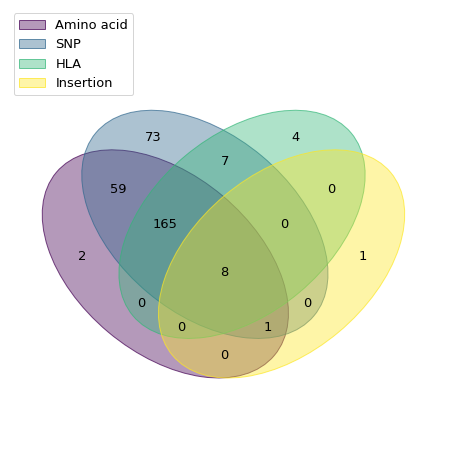

In [11]:
#count_groups = compute_counts_and_rel_ab(df)
compute_venn(df)
#plt.get_legend_handles_labels()
# Save and show
# plt.savefig('Supplementaries/HLA_associations_Venn_Agilent.png',
#         facecolor='white',
#         dpi=300,
#         transparent=False,
#         bbox_inches = 'tight')

319
158


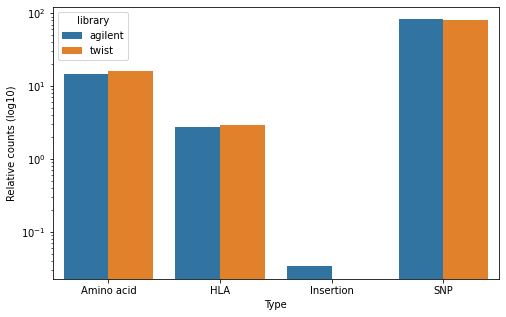

In [14]:
count_groups = compute_counts_and_rel_ab(df)

TypeError: vennx() got an unexpected keyword argument 'set_labels'

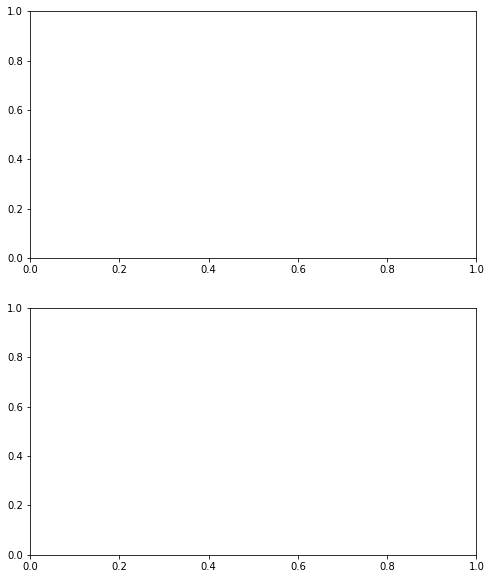

<Figure size 576x432 with 0 Axes>

In [17]:
# Now analyze df 2
df2[df2['peptide'].str.contains('agilent')]['TEST'].unique()

# get all single peptides
libraries = ['agilent', 'twist']
colors = [('purple', 'skyblue'), ('darkgrey', 'lightgreen')]

fig, axes = plt.subplots(nrows=2, figsize=(8,10))

for i,col,ax in zip(libraries, colors, axes):
    # peptides HLA and not HLA
    peptides_HLA = set(df[df['peptide'].str.contains(i)]['peptide'].unique().tolist())
    peptides_non_HLA = set(df2[df2['peptide'].str.contains(i)]['peptide'].unique().tolist())
    
    # Plot venn diagram
    plt.figure(figsize=(8,6))
    axis = venn2([peptides_HLA, peptides_non_HLA], 
          set_labels = ('HLA', 'all'),
          set_colors=col,
          alpha = 0.7,
         ax = ax)
    ax.set_title(i)
plt.savefig('HLA_vs_all_Venn_whole_agilent_twist.png',
        facecolor='white', 
        transparent=True);


In [19]:
agilent_total = pd.read_csv('data/df_agilent_with_info.csv', sep='\t')
#agilent_total

/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51676/3461434856.py:1: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  agilent_total = pd.read_csv('data/df_agilent_with_info.csv', sep='\t')


In [24]:
agilent_total['peptide'] = agilent_total['Unnamed: 0'].apply(lambda x: 'agilent_' + str(x))
agilent_total.drop('Unnamed: 0', axis=1, inplace=True)
                                                             

In [21]:
pd.merge(agilent_total, df[['peptide']], how='inner', on='peptide')['peptide']

0            agilent_42
1            agilent_42
2            agilent_42
3            agilent_42
4            agilent_42
              ...      
29807    agilent_243958
29808    agilent_243958
29809    agilent_243958
29810    agilent_243958
29811    agilent_243958
Name: peptide, Length: 29812, dtype: object

## Work on Agilent library (pkl complete info file)

Here we open the pickle, add peptide name column, and obtain a mapping table, containing all proteins (one row for protein, no duplicates) and on the peptides column we add a list containing

In [27]:
import pickle as pkl
mapped_peptides = agilent_total.groupby(['prot_num', 'full_aa_seq'])['peptide_name'].apply(lambda x: list( dict.fromkeys(x) )).reset_index()

pkl.dump(mapped_peptides, open('mapped_agilent_peptides.pkl', 'wb'))

In [28]:
def make_fasta(df, peptide=False):
    if peptide == False:
        with open('sequences_aa.fasta', 'wt') as s:
            for prot,seq in zip(df.iloc[1:]['prot_num'], df.iloc[1:]['full_aa_seq']):
                print(prot)
                if type(prot) == float or type(seq) == float:
                    pass
                else:
                    l = '>' + prot + '\n' + seq + '\n'
                    s.write(l)
            s.close()

make_fasta(mapped_peptides)

prot_1
prot_10
prot_100
prot_1000
prot_10000
prot_10001
prot_10002
prot_10003
prot_10004
prot_10005
prot_10006
prot_10007
prot_10008
prot_10009
prot_1001
prot_10010
prot_10011
prot_10012
prot_10013
prot_10014
prot_10015
prot_10016
prot_10017
prot_10018
prot_10019
prot_1002
prot_10020
prot_10021
prot_10022
prot_10023
prot_10024
prot_10025
prot_10026
prot_10027
prot_10028
prot_10029
prot_1003
prot_10030
prot_10031
prot_10032
prot_10033
prot_10034
prot_10035
prot_10036
prot_10037
prot_10038
prot_10039
prot_1004
prot_10040
prot_10041
prot_10042
prot_10043
prot_10044
prot_10045
prot_10046
prot_10047
prot_10048
prot_10049
prot_1005
prot_10050
prot_10051
prot_10052
prot_10053
prot_10054
prot_10055
prot_10056
prot_10057
prot_10058
prot_10059
prot_1006
prot_10060
prot_10061
prot_10062
prot_10063
prot_10064
prot_10065
prot_10066
prot_10067
prot_10068
prot_10069
prot_1007
prot_10070
prot_10071
prot_10072
prot_10073
prot_10074
prot_10075
prot_10076
prot_10077
prot_10078
prot_10079
prot_1008
prot_1